Data can be found on [Kaggle](https://www.kaggle.com/yersever/500-person-gender-height-weight-bodymassindex).

In [1]:
import pandas as pd
filename = "input/500_Person_Gender_Height_Weight_Index.csv"
df = pd.read_csv(filename)
df.head()

,Gender,Height,Weight,Index
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3


In [2]:
def convert_index_to_category(index):
    categories = ["Extremely Weak", "Weak", "Normal", "Overweight", "Obesity", "Extreme Obesity"]
    return categories[index]

In [3]:
def binary_gender_mapping(gender):
    if gender == "Male":
        return 1
    elif gender == "Female":
        return 0
    return -1

In [4]:
df.shape

(500, 4)

In [5]:
df.isnull().any()

Gender    False
Height    False
Weight    False
Index     False
dtype: bool

In [6]:
df.isna().any()

Gender    False
Height    False
Weight    False
Index     False
dtype: bool

In [7]:
formatted_data = df.copy()
formatted_data['Category'] = formatted_data['Index'].apply(convert_index_to_category)
formatted_data['Gender_mapping'] = formatted_data['Gender'].apply(binary_gender_mapping)

In [8]:
formatted_data.head()

,Gender,Height,Weight,Index,Category,Gender_mapping
0,Male,174,96,4,Obesity,1
1,Male,189,87,2,Normal,1
2,Female,185,110,4,Obesity,0
3,Female,195,104,3,Overweight,0
4,Male,149,61,3,Overweight,1


Text(0.5, 1.0, 'BMI')

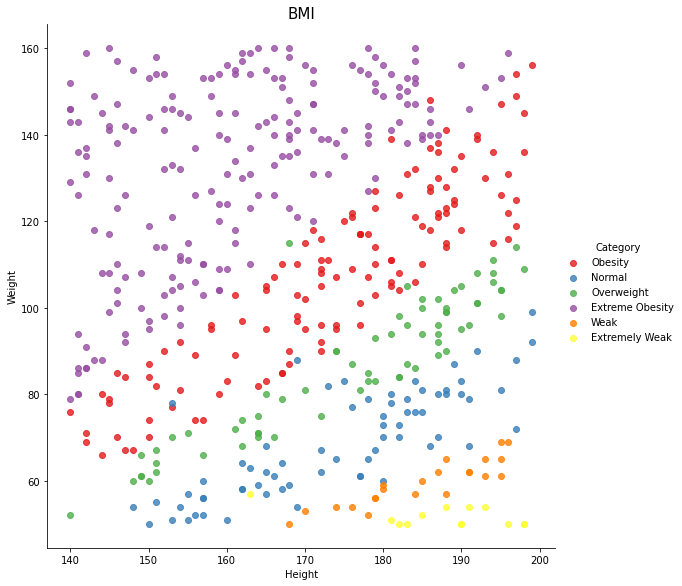

In [9]:
import seaborn as sns
import matplotlib as plt

sns.lmplot( x='Height', y='Weight', data=formatted_data, 
           fit_reg=False,
           hue='Category',
           legend=True, 
           palette='Set1',
           height = 8, 
           aspect = 1,
          )
ax = plt.pyplot.gca()
ax.set_title('BMI', size=15)


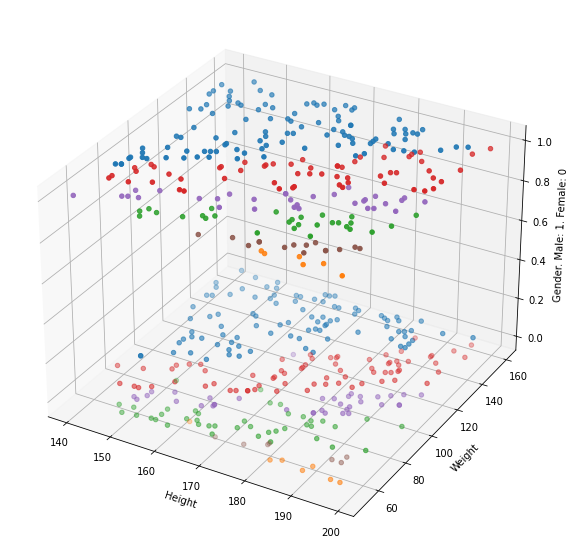

In [10]:
from mpl_toolkits.mplot3d import Axes3D

# https://matplotlib.org/stable/gallery/mplot3d/scatter3d.htmlfrom mpl_toolkits.mplot3d import Axes3D
fig = plt.pyplot.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
coordinates = formatted_data.groupby('Category')
for label, coordinate in coordinates:
    ax.scatter(coordinate.Height, coordinate.Weight, coordinate.Gender_mapping, label=label)
ax.set_xlabel('Height')
ax.set_ylabel('Weight')
ax.set_zlabel('Gender. Male: 1. Female: 0')
plt.pyplot.show()


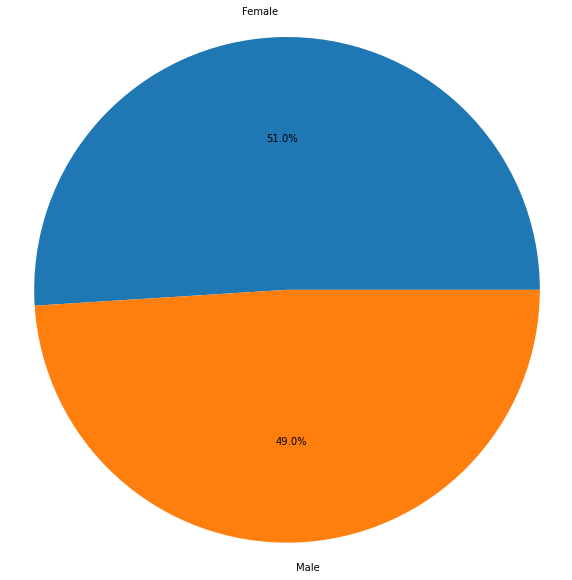

In [11]:
people = formatted_data['Gender'].value_counts()
label = ['Female', 'Male']
fig, ax = plt.pyplot.subplots(figsize=(10,10))
ax.pie(people,
       labels=label,
       autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.pyplot.show()

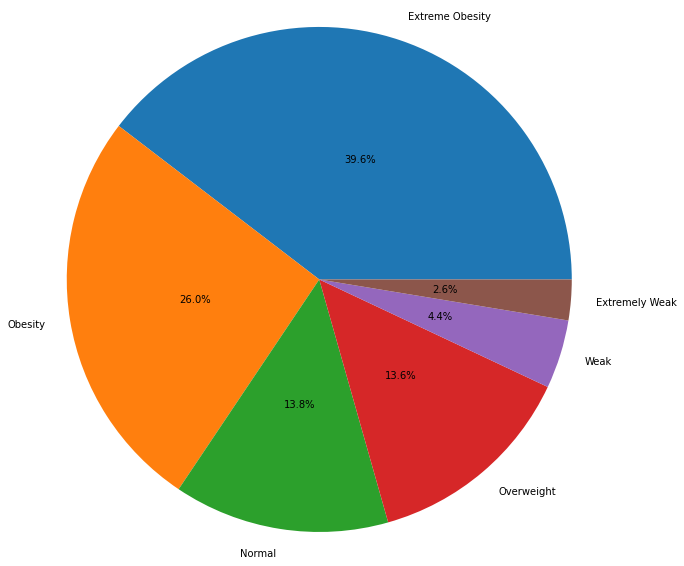

In [12]:
categories = formatted_data['Category'].value_counts()
categories_label = ['Extreme Obesity','Obesity','Normal','Overweight','Weak','Extremely Weak']
fig, ax = plt.pyplot.subplots(figsize=(10,10))
ax.pie(categories,
    labels=categories_label,
    autopct='%1.1f%%',
    radius=0.8,
    pctdistance=0.5)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.pyplot.show()

In [13]:
def encode_gender_data(df):
    from sklearn.preprocessing import LabelEncoder, OneHotEncoder
    from sklearn.compose import ColumnTransformer
    import numpy as np
    data = df.copy()
    ct = ColumnTransformer([('one_hot_encoder', OneHotEncoder(), [0])], remainder='passthrough')
    data = np.array(ct.fit_transform(data), dtype=np.float64)
    data = ct.fit_transform(data)
    data = pd.DataFrame(data)
    return data

In [14]:
def normalize_data(data):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    x = data.copy()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x)
    return x

In [37]:
def generate_test_and_train_data(data, test_size = 0.25):
    from sklearn.model_selection import train_test_split
    data = data.copy()
    x, y = data.iloc[:,:-1], data.iloc[:,-1]
    x = normalize_data(x)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size)
    return x_train, x_test, y_train, y_test

In [38]:
def generate_model(x_train, x_test, y_train, y_test):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import KFold, cross_validate
    clf = RandomForestClassifier(n_estimators=200, criterion='entropy')
    clf.fit(x_train, y_train)
    kf = KFold(shuffle=True, n_splits=10)
    score = cross_validate(clf, x_test, y_test, cv=kf, scoring='accuracy')
    return clf

In [39]:
data = encode_gender_data(df)
data.head()

,0,1,2,3,4,5
0,1.0,0.0,1.0,174.0,96.0,4.0
1,1.0,0.0,1.0,189.0,87.0,2.0
2,0.0,1.0,0.0,185.0,110.0,4.0
3,0.0,1.0,0.0,195.0,104.0,3.0
4,1.0,0.0,1.0,149.0,61.0,3.0


In [40]:
x_train, x_test, y_train, y_test = generate_test_and_train_data(data)
x_train.head()

,0,1,2,3,4
27,1.020204,-1.020204,1.020204,1.042614,-1.360115
396,1.020204,-1.020204,1.020204,1.042614,-0.309117
458,1.020204,-1.020204,1.020204,-0.974639,-0.772793
431,-0.980196,0.980196,-0.980196,-0.424479,1.483762
221,1.020204,-1.020204,1.020204,0.798099,0.989174


In [41]:
clf = generate_model(x_train, x_test, y_train, y_test)

In [42]:
from sklearn.metrics import accuracy_score
y_pred = clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.84

In [43]:
def health_test(people):
    data = pd.DataFrame(data = people, columns=['Gender','Height','Weight'])
    data = encode_gender_data(data)
    # Handle this warning https://stackoverflow.com/questions/69326639/sklearn-warnings-in-version-1-0
    y_pred = clf.predict(normalize_data(data.values))
    return [convert_index_to_category(int(v)) for v in y_pred.tolist()]

In [44]:
people = [['Female',155,78], ['Male',189,70]]
results = health_test(people)
results

['Extreme Obesity', 'Normal']